# **Libraries.**


In [ ]:
'''
    Import related libraries'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator, MaxNLocator

import cv2
from skimage import filters, morphology, measure
from google.colab import files
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, LinearLocator, FuncFormatter
from scipy.ndimage import gaussian_filter1d



# *Parameters*

In [ ]:
'''
   Field of view'''
FOV = 1000.00; # in microns.

# *Data upload*

In [ ]:
'''
   Upload'''
uploaded = files.upload();
file_path = list(uploaded.keys())[0];
sem_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE);

  # Ensure image is uint8//
sem_image = sem_image.astype(np.uint8)

  # Image dimensions//
height_pixels, width_pixels = sem_image.shape; # Extract height and width.
total_pixels = width_pixels * height_pixels;
print(f"Width: {width_pixels}, Height: {height_pixels}, Total Pixels: {total_pixels}");


Saving 200 um.png to 200 um.png
Width: 663, Height: 666, Total Pixels: 441558


# *Part A: Microcrack density*
# Processing (using Sobel detection).


In [ ]:
'''
   Preprocessing: Contrast enhancement using CLAHE'''
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8));
enhanced_image = clahe.apply(sem_image);

'''
   Noise reduction using Gaussian blur'''
blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0);

'''
   Sobel edge detection'''
edges_sobel = filters.sobel(blurred_image);

  # Thresholding//
threshold_value = filters.threshold_otsu(edges_sobel);
binary_image = edges_sobel > threshold_value;

  # Remove small objects to clean up binary image//
cleaned_image = morphology.remove_small_objects(binary_image, min_size=50);

  # Label the objects in the binary image//
labeled_image, num_features = measure.label(cleaned_image, return_num=True, connectivity=2);


# *Plot.*

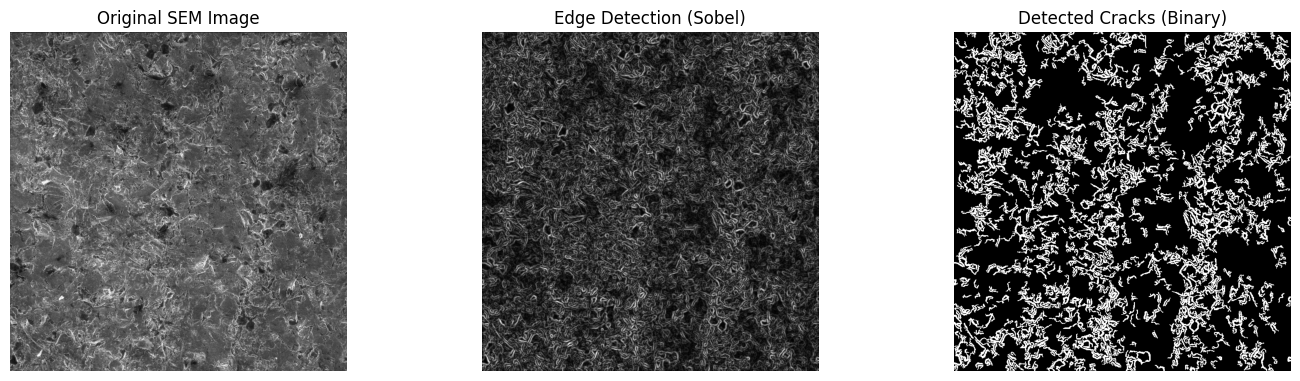

In [ ]:
'''
   Plotting images'''
fig, axes = plt.subplots(1, 3, figsize=(15, 5));
axes[0].imshow(sem_image, cmap='gray');
axes[0].set_title("Original SEM Image");
axes[0].axis("off");

axes[1].imshow(edges_sobel, cmap='gray');
axes[1].set_title("Edge Detection (Sobel)");
axes[1].axis("off");

axes[2].imshow(cleaned_image, cmap='gray');
axes[2].set_title("Detected Cracks (Binary)");
axes[2].axis("off");

plt.tight_layout();

# Save and download the plot//
file_name = "Edge detection.svg";
plt.tight_layout(pad=5.0); # Adjust layout to prevent cropping (i.e. Increase padding).
plt.savefig(file_name, format="svg", bbox_inches='tight'); # bbox_inches='tight' to prevent cutting off.
#files.download(file_name); # Download.

plt.show();


# *Results.*

In [ ]:
# Analyze cracks
print(f"Number of cracks detected: {num_features}");

regions = measure.regionprops(labeled_image);
total_crack_length = sum(region.perimeter for region in regions);
print(f"Total crack length: {total_crack_length:.2f} pixels");

total_crack_area = sum(region.area for region in regions);
print(f"Total crack area: {total_crack_area:.2f} pixels");

crack_density_per_pixel = num_features / total_pixels;
print(f"Crack density per pixel: {crack_density_per_pixel:.6f} cracks/pixel");

crack_density_per_field_of_view = num_features / (FOV ** 2);
print(f"Crack density per field of view (µm²): {crack_density_per_field_of_view:.6f} cracks/µm²");


Number of cracks detected: 327
Total crack length: 70008.08 pixels
Total crack area: 100579.00 pixels
Crack density per pixel: 0.000735 cracks/pixel
Crack density per field of view (µm²): 0.000327 cracks/µm²


# *Surface roughness*

In [ ]:
'''
   Read file'''
file_path = next(iter(uploaded));

# Read the image in grayscale//
sem_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE);
if sem_image is None:
    raise ValueError("Image not found or unable to load.");

# Calculate pixel size in micrometers//
pixel_size = FOV / width_pixels;

'''
   Apply algorithm'''
# Apply Gaussian blur to reduce noise//
blurred_image = cv2.GaussianBlur(sem_image, (5, 5), 0);

# Perform edge detection using Sobel operator//
sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3); # Sobel in x direction.
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3); # Sobel in y direction.

# Combine the two Sobel results to get the gradient magnitude//
edges = cv2.magnitude(sobel_x, sobel_y);

# Threshold the edge magnitude to detect significant edges//
_, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

# Find contours from the edges//
contours, _ = cv2.findContours(edges.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE);
if not contours:
    raise ValueError("No contours found in the image.");

'''
   Evaluate '''
# Select the largest contour assuming it represents the surface profile//
surface_contour = max(contours, key=cv2.contourArea);

# Extract x and y coordinates of the contour//
x_coords = surface_contour[:, 0, 0]; y_coords = surface_contour[:, 0, 1]

# Sort coordinates based on x values//
sorted_indices = np.argsort(x_coords); x_sorted = x_coords[sorted_indices]; y_sorted = y_coords[sorted_indices]

# Normalize the profile to remove any tilt or trend//
z_mean = np.mean(y_sorted); profile = y_sorted - z_mean

# Calculate the average roughness (Ra) in pixels
ra_pixels = np.mean(np.abs(profile))

# Calculate the root mean square roughness (Rq) in pixels
rq_pixels = np.sqrt(np.mean(profile**2))

# Convert roughness parameters to micrometers//
ra_micrometers = ra_pixels * pixel_size; rq_micrometers = rq_pixels * pixel_size;

'''
   Print'''
print(f"Average Roughness (Ra): {ra_micrometers:.2f} µm");
print(f"Root Mean Square Roughness (Rq): {rq_micrometers:.2f} µm");


Average Roughness (Ra): 278.99 µm
Root Mean Square Roughness (Rq): 315.49 µm


/tmp/ipython-input-30-2052554640.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=15.0); # Adjust layout to prevent cropping (i.e. Increase padding).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

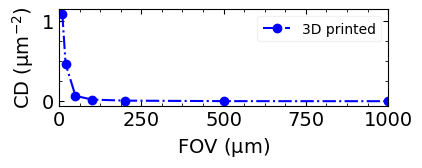

In [ ]:
'''
   SEM'''
fieldview = np.array([10, 20, 50, 100, 200, 500, 1000]); # Field view (in micron).
crackdensity_SEM_oven = np.array([1.09, 0.465, 0.0668, 0.021, 0.007475, 0.001184, 0.000327]);
#crackdensity_SEM_CuSputtered = np.array([1.3, 0.2125, 0.06, 0.028, 0.009775, 0.001932]);

'''
   Plot'''
fig, ax = plt.subplots(figsize=(4.25, 1.25));
ax.plot(fieldview, crackdensity_SEM_oven, marker="o", linestyle="-.", color="blue", label="3D printed");

# For x-and y-axis labeling//
ax.set_xlabel(r'FOV ($\mathrm{\mu}$m)', fontsize=14);
ax.set_ylabel(r'CD ($\mathrm{\mu m^{-2}}$)', fontsize=14);

# For x-and y-axis major(minor) ticks for all left(right) and up(down)//
ax.tick_params(which="both", axis="x", direction="in", bottom=True, top=True, labelsize=14);
ax.tick_params(which="both", axis="y", direction="in", left=True, right=True, labelsize=14);

# For x-and y-axis minor ticks locator//
ax.xaxis.set_minor_locator(AutoMinorLocator(4));
ax.yaxis.set_minor_locator(AutoMinorLocator(4));

# For x-and y-axis limiting//
start_x, end_x = ax.set_xlim(-1, 1000);
#start_y, end_y = ax.set_ylim(1e-6, 1.1);

# Text//
#plt.text(0.75, 0.75, r'$\theta_i$ = 30', horizontalalignment='center', fontsize = 14, transform = ax.transAxes, color = 'k');

# For vertical lines//
#plt.axvline(x=0, color='k', linestyle=':', linewidth=2.0);

# Legend//
legend = ax.legend(fontsize=10, loc='upper right', frameon=True, framealpha=0.25);

# Save and download the plot//
file_name = "Crack density oven.svg";
plt.tight_layout(pad=15.0); # Adjust layout to prevent cropping (i.e. Increase padding).
plt.savefig(file_name, format="svg", bbox_inches='tight'); # bbox_inches='tight' to prevent cutting off.
files.download(file_name); # Download.

# Show the plot//
plt.show();
